In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**FETCHING TOP 100K DATA**

In [11]:
import sqlite3
import pandas as pd
import numpy as np

db=sqlite3.connect('/content/gdrive/My Drive/amazon_data.sqlite')
main_data=pd.read_sql_query("""SELECT * FROM REVIEWS LIMIT 100000""",db)
db.close





<function Connection.close>

In [12]:
main_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedReview
0,138701,150519,0006641040,A12HY5OZ2QNK4N,Elizabeth H. Roessner,0,0,1,1256774400,It's a great book!,I've always loved chicken soup and rice. My la...,alway love chicken soup rice late ethel alway ...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
3,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...
4,138692,150510,0006641040,AM1MNZMYMS7D8,Dr. Joshua Grossman,0,0,1,1348358400,Professional Mentoring,TITLE: Chicken Soup with Rice<br />AUTHOR: Mau...,chicken soup rice respect submit


# **CHECKING FOR IMBALANCE**

In [13]:
main_data.Score.value_counts()

1    85257
0    14743
Name: Score, dtype: int64

**OBSERVATION**

1. THE DATA IS CLEARLY IMABALANCED AND THUS AUC SCORE IS THE PROPER METRIC 

**SORTING BASED ON TIME STAMP**

In [14]:
main_data=main_data.sort_values('Time', ascending=1)
  
main_data = main_data.reset_index(drop=True)

reviews=main_data.CleanedReview
Score=main_data.Score
 
reviews.shape

(100000,)

# **CLASSIFIER AND ACCURACY FUNCTIONS**

In [0]:
#def kNN function
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix
import seaborn as sn
import math
import time

alpha_values=np.linspace(0,10,100)

def misclassification(x):
  return 1-x

#HYPERPARAMETER TUNING


def BEST_LAMBDA(data):
    
    clf = LogisticRegression()
    
    parameters1 = {'C':[10**-5, 10**-4,10**-3,10**-2,10**-1,10**1,10**2,10**3,10**4,10**5],'penalty':['l2']}
    parameters2 = {'C':[10**-5, 10**-4,10**-3,10**-2,10**-1,10**1,10**2,10**3,10**4,10**5],'penalty':['l1']}
    
    model1=GridSearchCV(clf,parameters1,cv=5,scoring='roc_auc')
    model2=GridSearchCV(clf,parameters2,cv=5,scoring='roc_auc')
    model1.fit(data[0],data[1])
    model2.fit(data[0],data[1])
    
   
    print("Best lambda for the l2 regularization:",model1.best_params_)
    print("Best AUC-score:",model1.best_score_*100)
    df1 = pd.DataFrame(model1.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
  
    
    print("Best lambda for the l1 regularization:",model2.best_params_)
    print("Best AUC-score:",model2.best_score_*100)
    df2 = pd.DataFrame(model2.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
    
    print()
    
    
    ############################################################################################################
    
    f = plt.figure(figsize=(15,8))
    
    plt.subplot(1, 2, 1)
  
    plt.plot(np.log(parameters1['C']),df1['mean_train_score'].apply(misclassification),color='blue')
    
    plt.plot(np.log(parameters1['C']),df1['mean_test_score'].apply(misclassification),color='green')


    
    plt.title('AUC_Score Rate vs.Log of C Value for L2 regularization')
    plt.ylabel('MISCLASSIFICATION RATE')
    plt.xlabel('C Value')
    
    plt.legend(['Training Set', 'Cross Validation Set'], loc='upper right')
    
    
    ###########################################################################################################
    plt.subplot(1, 2, 2)
    
    plt.plot(np.log(parameters1['C']),df2['mean_train_score'].apply(misclassification),color='blue')
    
    plt.plot(np.log(parameters1['C']),df2['mean_test_score'].apply(misclassification),color='green')
    
    
    plt.title('AUC Score Rate vs.Log of  C Value for L1 regularization')
    plt.ylabel('MISCLASSIFICATION RATE')
    plt.xlabel('C Value')
    
    plt.legend(['Training Set', 'Cross Validation Set'], loc='upper right')
    
    plt.tight_layout()
    
    plt.show()

    
    
  
#BRUTE FORCE IMPLEMENTATION  

    
def nb_classifier(data,r,c,graph):
  
  start=time.time()
  
  clf = LogisticRegression(penalty=r,C=c)
    
  clf.fit(data[0],data[1])
  
  pred=clf.predict_proba(data[2])[:,1]

  score=roc_auc_score(data[3],pred)
 
  pred=np.round_(pred)
  
  if graph=="yes":
    
      matrix=confusion_matrix(data[3],pred)
      df=pd.DataFrame(matrix,index=['Positive','Negative'],columns=['Positive','Negative'])
      plt.figure(figsize = (10,7))
      sn.heatmap(df, annot=True,fmt='g')
      end=time.time()

      print("Time taken:",end-start)
  
  return score,clf



  
  

In [0]:
x=np.log([10**-5, 10**-4,10**-3,10**-2,10**-1,10**1,10**2,10**3,10**4,10**5])

In [25]:
x

array([-11.51292546,  -9.21034037,  -6.90775528,  -4.60517019,
        -2.30258509,   2.30258509,   4.60517019,   6.90775528,
         9.21034037,  11.51292546])

In [0]:
from sklearn.model_selection import train_test_split

def splitter(X,Y):
  
  X_train =  X[:int(math.ceil(main_data.shape[0])*.7)] 
  X_test = X[int(math.ceil(main_data.shape[0])*.7):]
  y_train = Y[:int(math.ceil(main_data.shape[0])*.7)]
  y_test =  Y[int(math.ceil(main_data.shape[0])*.7):]
  return (X_train, X_test, y_train, y_test)

def random_splitter(X,Y):
  
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
  return (X_train, X_test, y_train, y_test)

# **LOGISTIC REGRESSION FOR BAG OF WORDS**

In [21]:

BOW_TRAIN,BOW_TEST,Y_TRAIN,Y_TEST=splitter(reviews,Score)

print("Number of data points for TRAIN:",BOW_TRAIN.shape[0])
print("Number of data points for TEST",BOW_TEST.shape[0])
print("Number of data points for Y_TRAIN",Y_TRAIN.shape[0])
print("Number of data points for Y_TEST",Y_TEST.shape[0])

Number of data points for TRAIN: 70000
Number of data points for TEST 30000
Number of data points for Y_TRAIN 70000
Number of data points for Y_TEST 30000


**TRAIN**

In [0]:
#BOW

from sklearn import preprocessing

from sklearn.feature_extraction.text import CountVectorizer

vectorizer=CountVectorizer()

BOW=vectorizer.fit_transform(BOW_TRAIN)
BOW.shape

BOW=preprocessing.normalize(BOW)


**FINDING THE OPTIMAL VALUE OF ALPHA**

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best lambda for the l2 regularization: {'C': 10, 'penalty': 'l2'}
Best AUC-score: 93.43750023248036
Best lambda for the l1 regularization: {'C': 10, 'penalty': 'l1'}
Best AUC-score: 92.42327633076036



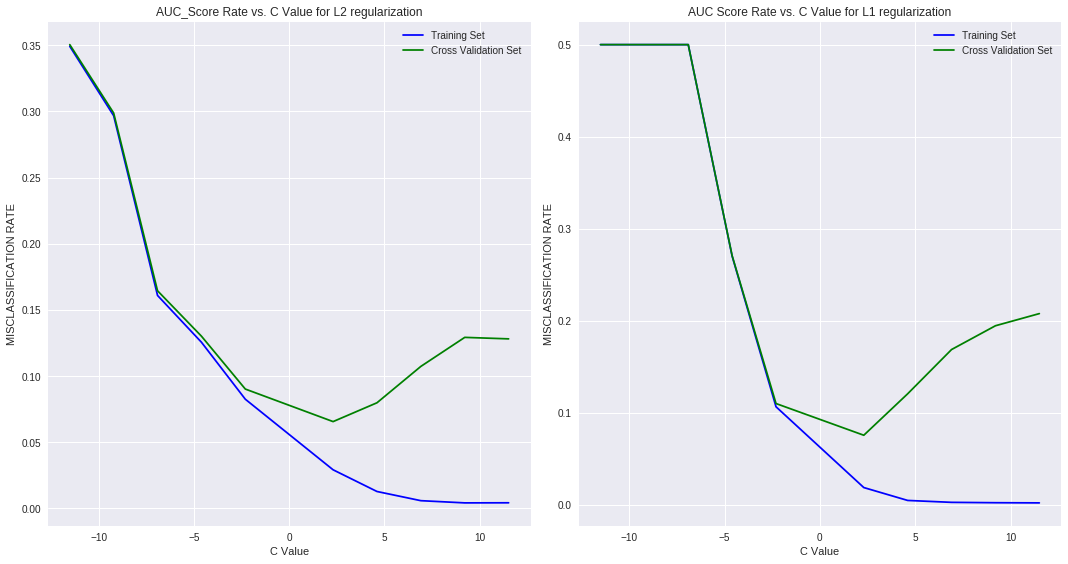

In [27]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

data=(BOW,Y_TRAIN)
BEST_LAMBDA(data)

**TESTING WITH OUR TEST DATA SET**

In [0]:
vectorizer=CountVectorizer()

vectorizer.fit(BOW_TRAIN)
BOW_TEST=vectorizer.transform(BOW_TEST)

BOW_TEST=preprocessing.normalize(BOW_TEST)
print(BOW_TEST.shape)



(30000, 27830)


Time taken: 2.3742966651916504


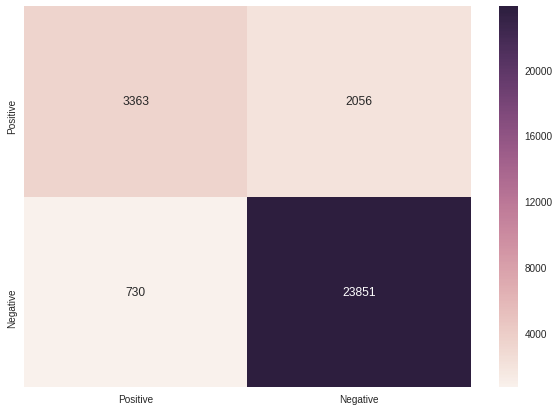

In [0]:

data=(BOW,Y_TRAIN,BOW_TEST,Y_TEST)
x=nb_classifier(data,"l2",10,"yes")

In [0]:
print("The AUC score for BOW for C=10",x[0])

The AUC score for BOW for C=10 0.9373269309741246


**SPARSITY CALCULATION**

In [0]:
x_sparse=nb_classifier(data,"l1",10,"no")

non_zero=np.count_nonzero(x_sparse[1].coef_)

total=x_sparse[1].coef_.shape[1]

sparsity=(total-non_zero)/total

print("The sparsity for BOW with C=10 :{}%".format(sparsity*100))

The sparsity for BOW with C=10 :80.3090190441969%


**PERTUBATION**

In [0]:

e=np.random.uniform(0,0.01)

In [0]:

BOW.data=BOW.data+e




In [0]:
w=x[1].coef_
print(w)
w=w+10**-6

data=(BOW,Y_TRAIN,BOW_TEST,Y_TEST)
x_new=nb_classifier(data,"l2",10,graph="no")




[[0.02764292 0.0387187  0.01076705 ... 0.05372894 0.00345369 0.00563066]]


In [0]:
w_new=x_new[1].coef_
w_new=w_new+10**-6


In [0]:
delta=abs((w-w_new)/w)*100
print(delta.max())
print(delta.mean())
print(delta.min())




174284.78221268835
13.649318457240485
0.0004587601968291967


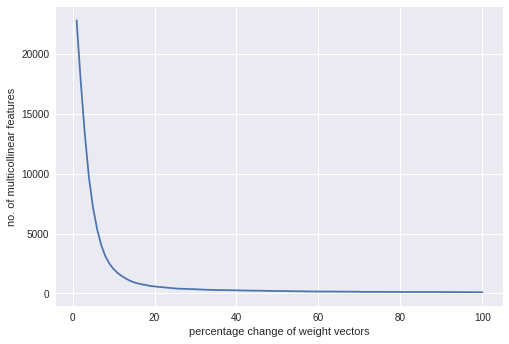

In [0]:
percentage=[]
features=[]

for i in range(1,101):
    n=np.where(delta > i)[1].size
    percentage.append(i)
    features.append(n)

plt.xlabel('percentage change of weight vectors')
plt.ylabel('no. of multicollinear features')
plt.plot(percentage,features)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: numpy.percentile
  


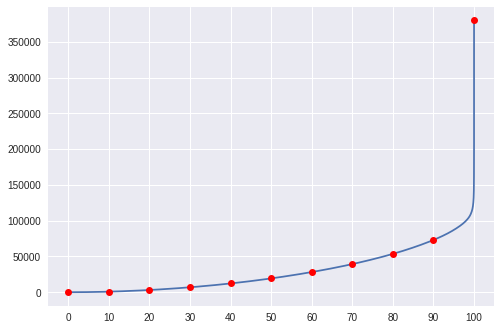

In [0]:
#code reference https://www.kaggle.com/souravdas4/amazon-food-reviews-using-logisticregression

from matplotlib import mlab

d = np.sort(delta).cumsum()
p = np.array(range(0,101,10))
perc = mlab.prctile(d, p=p)
plt.plot(d)

# Place red dots on the percentiles
plt.plot((len(d)-1) * p/100., perc, 'ro')

# Set tick locations and labels
plt.xticks((len(d)-1) * p/100., map(str, p))

plt.show()
  

**DECISION MAKING**

WE OBSERVE THAT THERE IS A STEEP SLOPE AT 99 PERCENTILE HENCE 99 PERCENTILE SHOULD BE CHECKED


In [0]:
perc=np.linspace(99.1,100,10)

for i in perc:
  print("{} percentile - {}".format(i,np.percentile(delta,i)))
  

99.1 percentile - 41.645076607218094
99.19999999999999 percentile - 46.72386942311431
99.3 percentile - 52.76862246600194
99.39999999999999 percentile - 58.79846071714154
99.5 percentile - 70.35029666916596
99.6 percentile - 93.99669024050088
99.7 percentile - 124.10264010665969
99.8 percentile - 202.00847608694167
99.9 percentile - 448.65781099061945
100.0 percentile - 174284.78221268835


WE SEE THAT THERE IS A SUDDEN JUMP AFTER **99.7** PERCENTILE THUS IT IS TAKEN TO BE THE THRESHOLD

In [0]:
features=np.where(delta>np.percentile(delta,99.7))[1]

FEATURES CORRESPOIND TO THRESHOLD

In [0]:
names=vectorizer.get_feature_names()

for i in features:
  print(names[i],end=" ")
print()  
  
  
print("Number of features :",len(features))  

adolesc assam attend baklawa barbecu behold blew bump charle chowder conclud contempl convien cotton dave digust disast disgruntl earliest eleph everytim extrud fault felin florist frantic fungi gaug germin ginger grand houston humili hysteria idaho infam kitchen krusteaz licens loath lou loud meh meringu mojo nutella oodl parch parmesan plump popsicl potti produc puchas purch raini revolut rottweil russian satisif sesam setter smore squeak station stinki subpar subsitut tan tantrum teeter tequila tower toxin trek tripl trough tweak variet verifi volatil wholesal worthi yellowish 
Number of features : 84





**TOP 10 MOST IMPORTANT FEATURES**

In [0]:
def most_informative_feature_for_binary_classification(vectorizer, classifier):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    coefs = sorted(zip(classifier.coef_[0], feature_names))
    topn_class1 = coefs[:10]
    topn_class2 = coefs[:-(11):-1]

    print("Top 10 negative features")
    for i in topn_class1:
       print(i)

    print("************************")
    print("Top 10 positive features")
    for i in topn_class2:
      print(i)
        

most_informative_feature_for_binary_classification(vectorizer,x[1])

Top 10 negative features
(-14.380953319856445, 'worst')
(-11.096488909257678, 'aw')
(-9.707016739010113, 'terribl')
(-9.342530586357771, 'horribl')
(-9.12296220134365, 'wors')
(-9.09415956224729, 'tasteless')
(-8.76265419403739, 'threw')
(-8.429898226308186, 'disappoint')
(-8.429581263798745, 'flavorless')
(-8.274010318635218, 'disgust')
************************
Top 10 positive features
(10.358048734462363, 'addict')
(8.927919621279978, 'awesom')
(8.83045192964219, 'hook')
(8.710233956934426, 'skeptic')
(8.257061614871649, 'delici')
(8.126525940842614, 'amaz')
(8.052507059117717, 'perfect')
(8.037385219467291, 'excel')
(7.739665206549041, 'best')
(7.70862528272939, 'beat')


**ADDING EXTRA FEATURE : LENGTH OF REVIEWS**

In [0]:
from scipy.sparse import coo_matrix, hstack

def review_len(x):
  
  return len(x)

feature_len=main_data['CleanedReview'][:70000]
feature_len=feature_len.apply(review_len)

feature_len=feature_len.reshape(70000,1)
print(feature_len)

BOW=hstack([BOW,feature_len])

BOW=BOW.tocsr()

[[191]
 [181]
 [ 85]
 ...
 [228]
 [ 47]
 [ 71]]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Best lambda for the l2 regularization: {'C': 10, 'penalty': 'l2'}
Best AUC-score: 93.43750023248036
Best lambda for the l1 regularization: {'C': 10, 'penalty': 'l1'}
Best AUC-score: 92.42350876739593



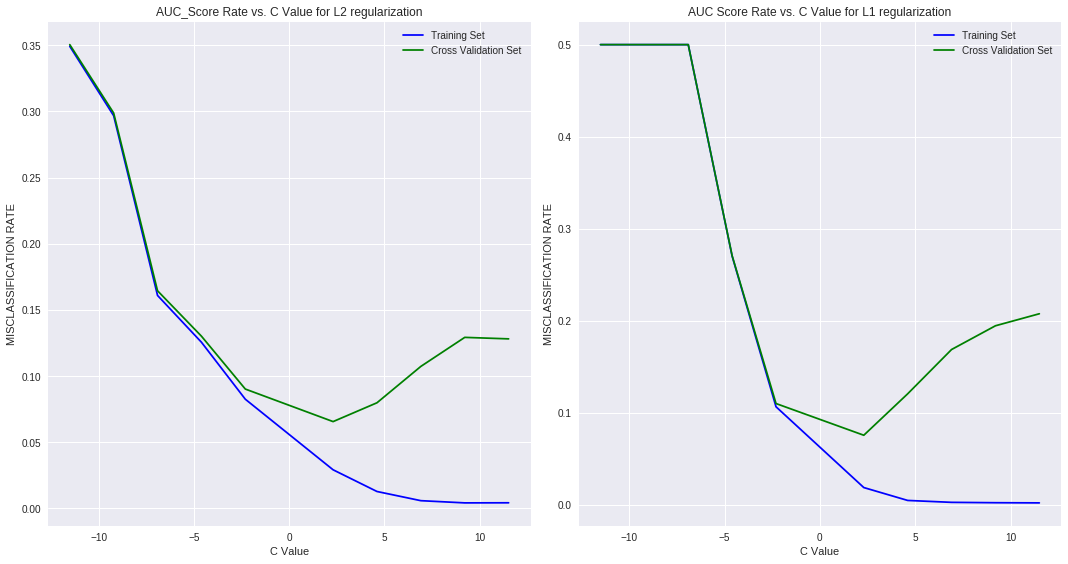

In [28]:


data=(BOW,Y_TRAIN)
alpha=BEST_LAMBDA(data)

In [0]:
feature_len=main_data['CleanedReview'][70000:100001]
feature_len=feature_len.apply(review_len)
feature_len=np.array(feature_len)
feature_len=feature_len.reshape(30000,1)
print(feature_len.shape)
BOW_TEST=hstack([BOW_TEST,feature_len])

(30000, 1)


Time taken: 3.2841877937316895


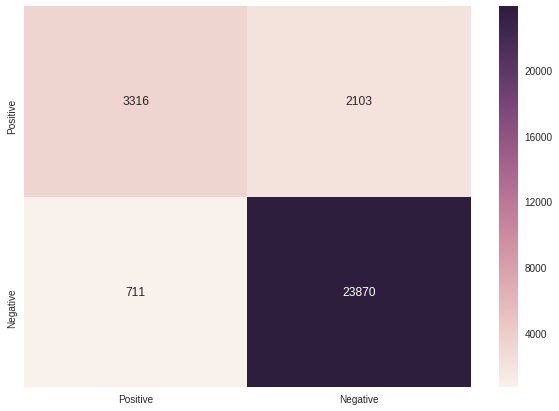

In [0]:

BOW_TEST=BOW_TEST.tocsr()

data=(BOW,Y_TRAIN,BOW_TEST,Y_TEST)
x_extra=nb_classifier(data,"l2",10,"yes")

In [0]:
print("The AUC score for BOW for alpha={} : {} with a additional feature".format(10,x_extra[0]))

The AUC score for BOW for alpha=10 : 0.9370574880015823 with a additional feature


**OBSERVATIONS**

1.   THE OPTIMAL VALUE OF C 

Best lambda for the l2 regularization: {'C': 10, 'penalty': 'l2'}
Best AUC-score: 93.43750023248036
Best lambda for the l1 regularization: {'C': 10, 'penalty': 'l1'}
Best AUC-score: 92.42250726120976

2.   TOTAL  AUC-SCORE FOR TEST DATASET COMES OUT TO BE 93.73%
3.   ON ADDITING AN EXTRA FEATURE  THERE IS NO CHANGE IN THE AUC SCORE AS AFTER CHANGE AUC IS STILL 93.7%
4.   THE SPARSITY WAS CALCULATED TO BE 80% FOR C=10
5.   THE THRESHOLD ABOVE WHICH THE WEIGHTS CHANGED DRASTICALLY WAS FOUND TO BE 99.7%



# **LOGISTIC REGRESSION FOR TF-IDF**

In [30]:
tf_TRAIN,tf_TEST,Y_TRAIN,Y_TEST=splitter(reviews,Score)

print("Number of data points for TRAIN:",tf_TRAIN.shape[0])
print("Number of data points for TEST",tf_TEST.shape[0])



Number of data points for TRAIN: 70000
Number of data points for TEST 30000


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer(ngram_range=(1,2))
tf_idf=vectorizer.fit_transform(tf_TRAIN)
tf_idf.shape



(70000, 775317)

**SPLITTING DATA**

**FINDING OPTIMAL VALUE OF ALPHA**

Best lambda for the l2 regularization: {'C': 10, 'penalty': 'l2'}
Best AUC-score: 94.57633195431409
Best lambda for the l1 regularization: {'C': 10, 'penalty': 'l1'}
Best AUC-score: 93.76982032114347



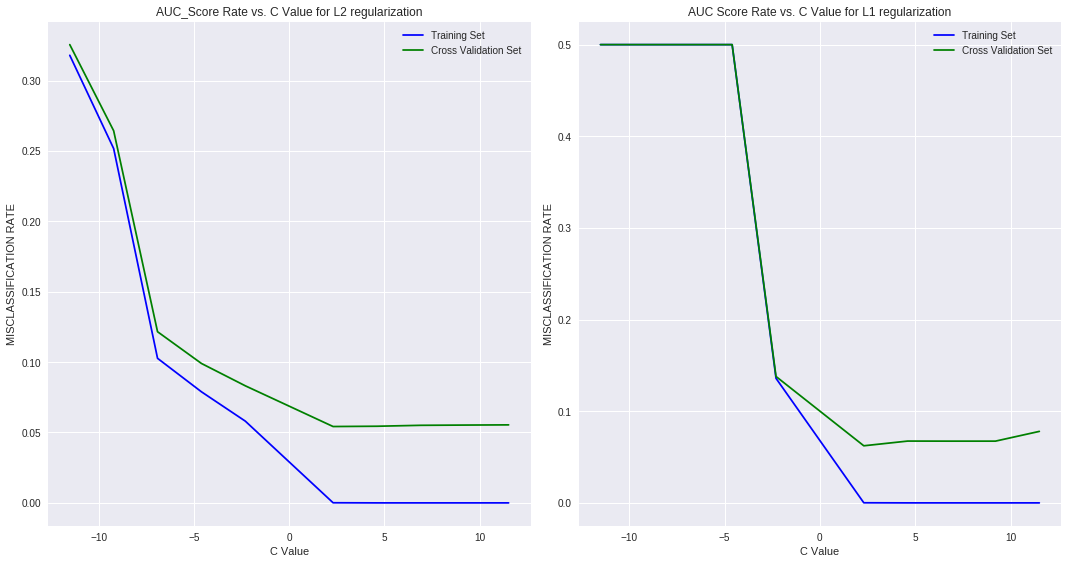

In [32]:

data=(tf_idf,Y_TRAIN)
BEST_LAMBDA(data)

**TRAINING AND TESTING DATA ON TEST DATA SET**

In [0]:


vectorizer.fit(tf_TRAIN)
tf_TEST=vectorizer.transform(tf_TEST)
print(tf_TEST.shape)

(30000, 775317)


In [0]:
print(tf_idf.shape,Y_TRAIN.shape,tf_TEST.shape,Y_TEST.shape)

(70000, 775317) (70000,) (30000, 775317) (30000,)


Time taken: 4.695466041564941


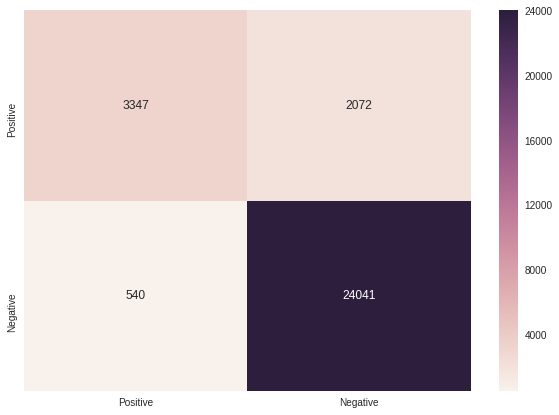

In [0]:

data=(tf_idf,Y_TRAIN,tf_TEST,Y_TEST)
auc=nb_classifier(data,"l2",10,"yes")

In [0]:
print("The AUC score for TF-IDF with C=10 : {}:".format(auc[0]))

The AUC score for TF-IDF with C=10 : 0.9483693182327053:


**TOP 10 MOST IMPORTANT FEATURES**

In [0]:

def most_informative_feature_for_binary_classification(vectorizer, classifier):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    coefs = sorted(zip(classifier.coef_[0], feature_names))
    topn_class1 = coefs[:10]
    topn_class2 = coefs[:-(11):-1]

    print("Top 10 negative features")
    for i in topn_class1:
       print(i)

    print("************************")
    print("Top 10 positive features")
    for i in topn_class2:
      print(i)

most_informative_feature_for_binary_classification(vectorizer,auc[1])

Top 10 negative features
(-17.41415594357827, 'disappoint')
(-15.953783437019357, 'worst')
(-13.045012033025998, 'aw')
(-12.614181003020638, 'terribl')
(-11.45105050937541, 'horribl')
(-10.659692584854639, 'bland')
(-10.529660538443208, 'threw')
(-10.102658725490986, 'stale')
(-10.033729477588958, 'unfortun')
(-9.944201328173957, 'return')
************************
Top 10 positive features
(19.623996035886382, 'great')
(18.12045963210216, 'best')
(16.679660479867884, 'love')
(16.06388392256376, 'delici')
(13.794829110204573, 'perfect')
(13.32589158633472, 'excel')
(11.866577420632158, 'high recommend')
(10.587409391949619, 'favorit')
(10.38855783577246, 'good')
(10.094277441982658, 'addict')


**OBSERVATION**

1. OPTIMAL VALUE OF C

Best lambda for the l2 regularization: {'C': 10, 'penalty': 'l2'}
Best AUC-score: 93.47232954317155
Best lambda for the l1 regularization: {'C': 10, 'penalty': 'l1'}
Best AUC-score: 92.38776897070491

2. THE TOTAL AUC SCORE FOR TEST DATA WAS FOUND TO BE 94.8 L2 REGULARIZED

# **WORD2VEC**

In [34]:
w2v_TRAIN,w2v_TEST,Y_TRAIN,Y_TEST=splitter(reviews,Score)

print("Number of data points for TRAIN:",w2v_TRAIN.shape[0])
print("Number of data points for TEST",w2v_TEST.shape[0])
print("Number of data points for Y_TRAIN",Y_TRAIN.shape[0])
print("Number of data points for Y_TEST",Y_TEST.shape[0])


Number of data points for TRAIN: 70000
Number of data points for TEST 30000
Number of data points for Y_TRAIN 70000
Number of data points for Y_TEST 30000


In [0]:

tokenized_sentences=[]
for sentence in w2v_TRAIN:
    tokenized_sentences.append(sentence.split())

    

In [36]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

word2vec_model=Word2Vec(tokenized_sentences,min_count=5,size=50,workers=4)

word2vec_list=word2vec_model.wv.vocab

word2vec_list=list(word2vec_list)


print(word2vec_list)

['littl', 'book', 'make', 'son', 'laugh', 'loud', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'learn', 'india', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'rememb', 'see', 'show', 'air', 'televis', 'year', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirti', 'someth', 'use', 'seri', 'song', 'student', 'teach', 'preschool', 'turn', 'whole', 'school', 'purchas', 'children', 'tradit', 'live', 'beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'twist', 'captur', 'film', 'star', 'michael', 'keaton', 'geena', 'davi', 'prime', 'tim', 'burton', 'masterpiec', 'rumbl', 'absurd', 'wonder', 'pace', 'point', 'dull', 'moment', 'funni', 'hilari', 'wacki', 'great', 'help', 'think', 'one', 'best', 'ever', 'made', 'sure', 'agre', 'good', 'time', 'watch', 'collect', 'fill', 'comedi', 'action', 'whatev', 'els', 'want', 'call', 'enjoy', 'entertain', 'hesit', 'pi

In [37]:

from tqdm import tqdm


sentences=[]

for sentence in tqdm(tokenized_sentences):
  count=0
  avg_sentence=np.zeros(50)
  for word in sentence:
    if word in word2vec_list:
      avg_sentence+=word2vec_model.wv[word]
      count+=1
      
  if count!=0:
    
    avg_sentence/=count
  
  sentences.append(avg_sentence)
  

100%|██████████| 70000/70000 [01:13<00:00, 955.88it/s]


In [0]:
sentences=np.array(sentences)
sentences.shape
word2vec=sentences

In [0]:
word2vec=preprocessing.normalize(word2vec)

**TEST DATA PREP**


In [0]:
tokenized_sentences_test=[]
for sentence in w2v_TEST:
    tokenized_sentences_test.append(sentence.split())

In [0]:
word2vec_test=Word2Vec(tokenized_sentences_test,min_count=5,size=50,workers=4)

In [0]:
word2vec_list_test=word2vec_test.wv.vocab

word2vec_list_test=list(word2vec_list_test)

In [43]:
from tqdm import tqdm


sentences=[]

for sentence in tqdm(tokenized_sentences_test):
  count=0
  avg_sentence=np.zeros(50)
  for word in sentence:
    if word in word2vec_list_test:
      avg_sentence+=word2vec_test.wv[word]
      count+=1
      
  if count!=0:
    
    avg_sentence/=count
  
  sentences.append(avg_sentence)
  

100%|██████████| 30000/30000 [00:22<00:00, 1359.67it/s]


In [0]:
sentences=np.array(sentences)
sentences.shape
word2vec_test=sentences

In [0]:
word2vec_test=preprocessing.normalize(word2vec_test)

**BEST VALUE OF C**

Best lambda for the l2 regularization: {'C': 10, 'penalty': 'l2'}
Best AUC-score: 89.17284971763453
Best lambda for the l1 regularization: {'C': 10, 'penalty': 'l1'}
Best AUC-score: 89.17213754070866



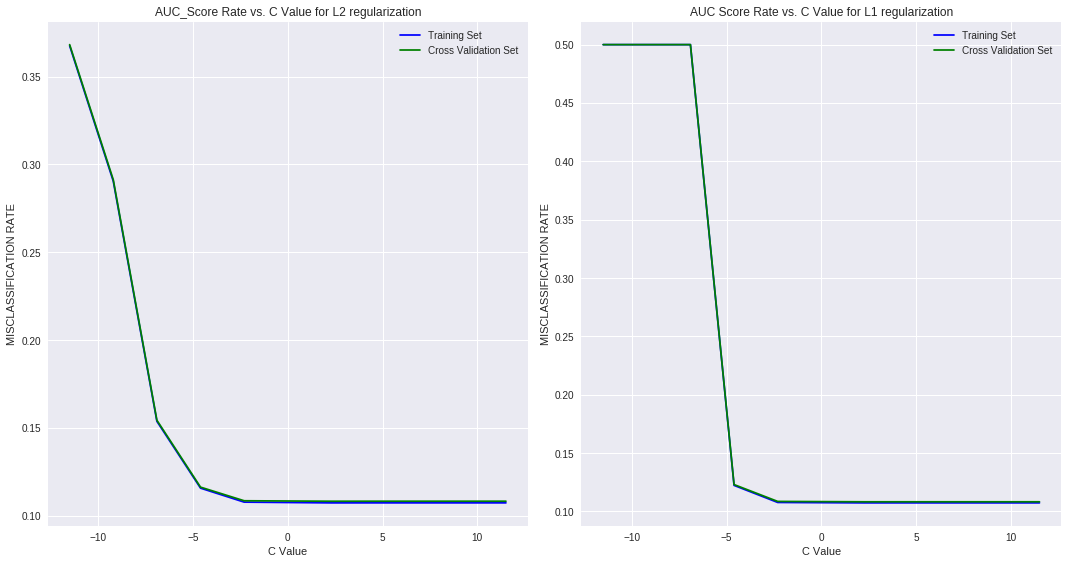

In [46]:
data=(word2vec,Y_TRAIN)

BEST_LAMBDA(data)

Time taken: 1.6053223609924316


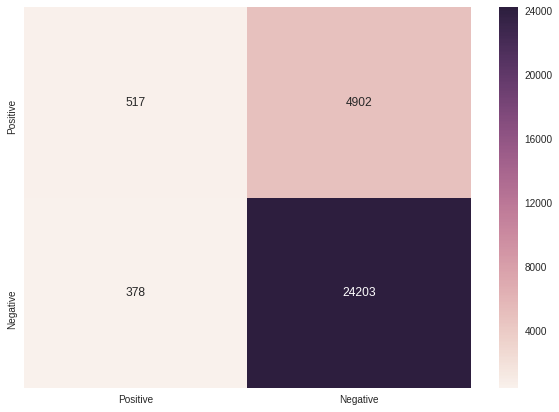

In [47]:
data=(word2vec,Y_TRAIN,word2vec_test,Y_TEST)
auc=nb_classifier(data,"l2",0.1,"yes")

In [48]:
print("The AUC score for word2vec with C=0.1 : {}:".format(auc[0]))

The AUC score for word2vec with C=0.1 : 0.744154697427163:


**TOP 10 MOST IMPORTANT FEATURES**


In [49]:

def most_informative_feature_for_binary_classification(vectorizer, classifier):
    class_labels = classifier.classes_
    feature_names = word2vec_model.wv.vocab
    coefs = sorted(zip(classifier.coef_[0], feature_names))
    topn_class1 = coefs[:10]
    topn_class2 = coefs[:-(11):-1]

    print("Top 10 negative features")
    for i in topn_class1:
       print(i)

    print("************************")
    print("Top 10 positive features")
    for i in topn_class2:
      print(i)

most_informative_feature_for_binary_classification(word2vec_model,auc[1])

Top 10 negative features
(-2.7638739820761082, 'child')
(-2.7048328757192617, 'littl')
(-2.4376380508741673, 'teach')
(-2.3537360854475105, 'son')
(-2.005874210989304, 'whole')
(-1.869315077756634, 'air')
(-1.8324974635123328, 'new')
(-1.7331403510648713, 'still')
(-1.6762110120113427, 'refrain')
(-1.6472308793062809, 'love')
************************
Top 10 positive features
(3.3335132168099446, 'memori')
(3.0884753032848455, 'along')
(3.0607296832237827, 'introduc')
(2.950893680401403, 'turn')
(2.888107728762932, 'day')
(2.2799031205498483, 'car')
(2.266959475326157, 'rememb')
(2.0438209663566975, 'silli')
(1.993235853987187, 'student')
(1.9874500631698453, 'later')


**OBSERVATION**

OPTIMAL VALUE OF C

Best lambda for the l2 regularization: {'C': 10, 'penalty': 'l2'}
Best auc-score: 88.95828718119165
Best lambda for the l1 regularization: {'C': 10, 'penalty': 'l1'}
Best auc-score: 88.957392917416

THE TOTAL AUC SCORE FOR TEST DATA WAS FOUND TO BE 82.9 L2 REGULARIZED

# **TF-IDF WORD2VEC**

In [50]:
w2v_tf_TRAIN,w2v_tf_TEST,Y_TRAIN,Y_TEST=splitter(reviews,Score)

print("Number of data points for TRAIN:",w2v_TRAIN.shape[0])
print("Number of data points for TEST",w2v_TEST.shape[0])
print("Number of data points for Y_TRAIN",Y_TRAIN.shape[0])
print("Number of data points for Y_TEST",Y_TEST.shape[0])


Number of data points for TRAIN: 70000
Number of data points for TEST 30000
Number of data points for Y_TRAIN 70000
Number of data points for Y_TEST 30000


In [0]:
tf_idf_model=TfidfVectorizer()
tf_idf_vector=tf_idf_model.fit_transform(w2v_tf_TRAIN)

dictionary=dict(zip(tf_idf_model.get_feature_names(),list(tf_idf_model.idf_)))

In [52]:
tf_idf_feature=tf_idf_model.get_feature_names()
tf_idf_w2v=[]
for sentence in tqdm(tokenized_sentences):
    tfidf_sum=0
    sent_vec=np.zeros(50)
    for word in sentence:
        if word in word2vec_list:
            vec=word2vec_model.wv[word]
            
            tf_idf=dictionary[word]*(sentence.count(word)/len(sentence))
            sent_vec+=vec*tf_idf
            tfidf_sum+=tf_idf
    if tfidf_sum!=0:
        sent_vec/=tfidf_sum
    tf_idf_w2v.append(sent_vec)
    

100%|██████████| 70000/70000 [01:41<00:00, 690.46it/s]


In [53]:
tf_idf_w2v=np.array(tf_idf_w2v)
tf_idf_w2v.shape

(70000, 50)

**BEST HYPERPARAMETER**

Best lambda for the l2 regularization: {'C': 0.1, 'penalty': 'l2'}
Best AUC-score: 86.83153329059898
Best lambda for the l1 regularization: {'C': 0.1, 'penalty': 'l1'}
Best AUC-score: 86.8278482745253



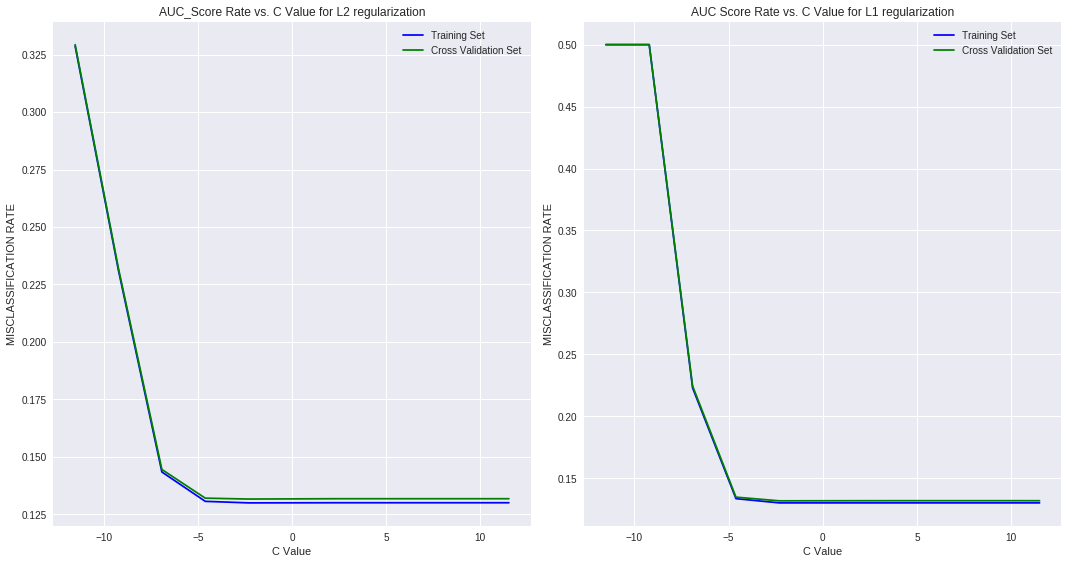

In [54]:
data=(tf_idf_w2v,Y_TRAIN)
k=BEST_LAMBDA(data)

In [0]:
tf_idf_model=TfidfVectorizer()
tf_idf_vector=tf_idf_model.fit(w2v_tf_TRAIN)
tf_idf_test=tf_idf_model.transform(w2v_tf_TEST)

dictionary=dict(zip(tf_idf_model.get_feature_names(),list(tf_idf_model.idf_)))

In [56]:
tf_idf_feature=tf_idf_model.get_feature_names()
tf_idf_w2v_test=[]
for sentence in tqdm(tokenized_sentences_test):
    tfidf_sum=0
    sent_vec=np.zeros(50)
    for word in sentence:
        if word in word2vec_list:
            vec=word2vec_model.wv[word]
            
            tf_idf=dictionary[word]*(sentence.count(word)/len(sentence))
            sent_vec+=vec*tf_idf
            tfidf_sum+=tf_idf
    if tfidf_sum!=0:
        sent_vec/=tfidf_sum
    tf_idf_w2v_test.append(sent_vec)
    

100%|██████████| 30000/30000 [00:45<00:00, 662.58it/s]


Time taken: 2.439457416534424


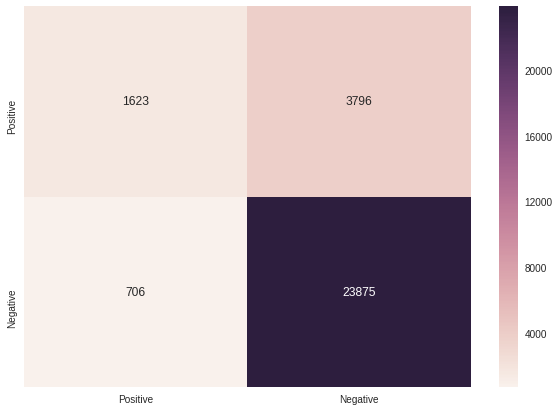

In [57]:
data=(tf_idf_w2v,Y_TRAIN,tf_idf_w2v_test,Y_TEST)
auc=nb_classifier(data,"l2",0.1,"yes")

In [58]:
print("The AUC score for TF-IDF-word2vec with C=0.1 : {}:".format(auc[0]))

The AUC score for TF-IDF-word2vec with C=0.1 : 0.8646113212488362:


**OBSERVATION**

1. THE OPTIMAL VALUE OF C

Best lambda for the l2 regularization: {'C': 0.1, 'penalty': 'l2'}
Best f1-score: 86.56735583108292
Best lambda for the l1 regularization: {'C': 0.1, 'penalty': 'l1'}
Best f1-score: 86.5654373151902

2.THE AUC SCORE FOR C=0.1 L2R IS FOUND TO BE  85.9%

In [59]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Text To Vector", "REGULARIZATION ","ADDITIONAL FEATURES" ,"C","AUC Score"]

x.add_row(["BOW","L2" ,"NO", 10, "93.74%" ])
x.add_row(["BOW", "L2","YES", 10, "93.76%"])
x.add_row(["TFIDF", "L2","-", 10,"94.8%" ])
x.add_row(["WORD2VEC", "L2","-", 0.1,"82.9%"])
x.add_row(["TFIDF-WORD2VEC","L2","-", 0.1,"85.9%" ])
print(x)

+----------------+-----------------+---------------------+-----+-----------+
| Text To Vector | REGULARIZATION  | ADDITIONAL FEATURES |  C  | AUC Score |
+----------------+-----------------+---------------------+-----+-----------+
|      BOW       |        L2       |          NO         |  10 |   93.74%  |
|      BOW       |        L2       |         YES         |  10 |   93.76%  |
|     TFIDF      |        L2       |          -          |  10 |   94.8%   |
|    WORD2VEC    |        L2       |          -          | 0.1 |   82.9%   |
| TFIDF-WORD2VEC |        L2       |          -          | 0.1 |   85.9%   |
+----------------+-----------------+---------------------+-----+-----------+


# **CONCLUSION**



1.   THE DATA WAS FOUND TO BE IMBALANCED AND THUS AUC SCORE WAS THE APPROPRIATE METRIC .
2.   THE OPTIMAL VALUE OF C VARIED SLIGHTLY FOR BETWEEN 0.1 TO 10.
3.   THERE IS A SIGNIFICANT NO DIFF IN AUC SCORE WHEN ADDITONAL FEATURE .
4.   THE HIGHEST AUC-SCORE WAS NOTED TO BE 94.8% FOR TF-IDF
5.   THE TENTATIVE AUC SCORE WAS FOUND TO BE AROUND 90%
6.    THE THREsHOLD WHERE THERE WAS A CHANGE IN WEIGHT WAS FOUND TO BE 99.7% WHEN CHECKING FOR MULTICOLINEARITY AND 82 FEATURES WHERE FOUND

